In [1]:
import sys
import os
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, multivariate_normal
from sklearn.mixture import GaussianMixture

from src.sampler import HMCSampler, MetropolisHastingsSampler
from src.density import CustomGaussian


# Define distribution

In [2]:
weights = np.array([0.1, 0.3, 1.3])
weights = weights / np.sum(weights)
means = np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 2.0]])
# covs = np.array([np.eye(d) * 0.5, np.eye(d) * 0.5, np.eye(d) * 0.5])
covs = np.array(
    [
        np.array([[0.7, 0.1], [0.1, 0.7]]),
        np.array([[0.5, -0.1], [-0.1, 0.5]]),
        np.array([[0.1, 0.0], [0.0, 0.1]]),
    ]
)

grad_weights = np.array([0.4, 0.3, 0.3])
grad_means = np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 2.0]])
grad_covs = np.array([np.eye(2) * 0.5, np.eye(2) * 0.5, np.eye(2) * 0.5])

custom_gaussian = CustomGaussian(
    weights, means, covs, grad_weights, grad_means, grad_covs
)

In [3]:
hmc = HMCSampler(custom_gaussian)

# Hamiltonian Monte Carlo Sampling

## Leapfrog a couple of samples

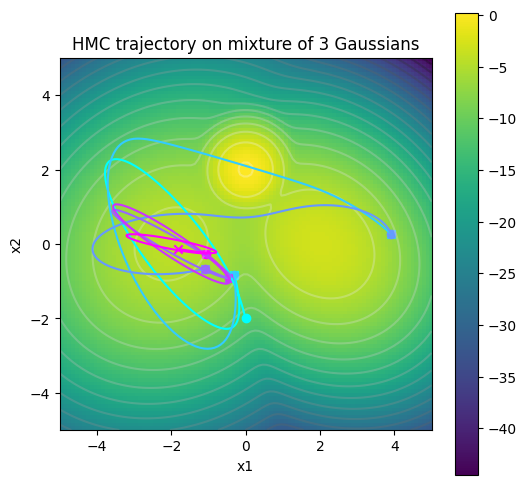

In [4]:
# Single long trajectory for visualisation
q0 = np.array([0.0, -2.0])
n_paths = 6
paths = []
for _ in range(n_paths):
    p0 = np.random.normal(size=2)

    q0, pT, path = hmc.leapfrog(x=q0, p=p0, leapfrog_steps=100, step_size=0.05)
    paths.append(path)

# Plot results
# Grid and contour plot
grid_lim = 5.0
xs = np.linspace(-grid_lim, grid_lim, 100)
ys = np.linspace(-grid_lim, grid_lim, 100)
X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -custom_gaussian.U([X[i, j], Y[i, j]])

fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20, cmap="Grays_r", alpha=0.3)
im = ax.imshow(
    Z,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin="lower",
    cmap="viridis",
    interpolation="nearest",
    aspect="auto",
)
# ax.clabel(cs, inline=True, fontsize=8)
colors = plt.cm.cool(np.linspace(0, 1, n_paths))
for i, path in enumerate(paths):
    ax.plot(path[:, 0], path[:, 1], color=colors[i])
    ax.scatter(path[0, 0], path[0, 1], marker="o", color=colors[i])
    ax.scatter(path[-1, 0], path[-1, 1], marker="x", color=colors[i])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC trajectory on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.colorbar(im)
plt.show()

## Sample points

In [5]:
# np.random.seed(0)

dim = 2
n_samples = 1000
leapfrog_steps = 20
step_size = 0.1
initial_q = np.array([0.0, 0.0])

start = perf_counter()
samples_hmc, acceptance_rate_hmc = hmc.sample(
    n_samples,
    leapfrog_steps,
    initial_q,
    step_size,
    dim,
)
time_hmc = perf_counter() - start

print(f"HMC sampling took {time_hmc:.3f} seconds.")
print(f"HMC acceptance rate: {acceptance_rate_hmc:.3f}")

HMC sampling took 0.771 seconds.
HMC acceptance rate: 0.695


## Plot samples

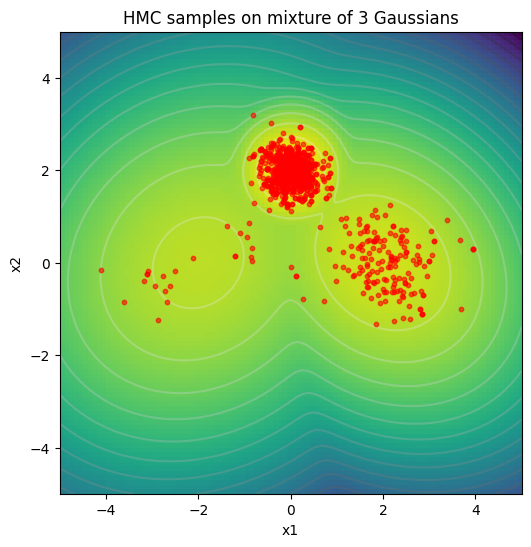

In [6]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20, cmap="Grays_r", alpha=0.3)
im = ax.imshow(
    Z,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin="lower",
    cmap="viridis",
    interpolation="nearest",
    aspect="auto",
)
ax.scatter(samples_hmc[:, 0], samples_hmc[:, 1], color="red", s=10, alpha=0.6, zorder=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC samples on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

# Metropolis Hastings Sampling

In [7]:
metropolis_sampler = MetropolisHastingsSampler(custom_gaussian)

In [8]:
# Plot the full path of Metropolis samples
q0 = np.array([0.0, -2.0])
start = perf_counter()
samples_metropolis, acc_rate = metropolis_sampler.sample(
    n_samples,
    proposal_scale=0.5,
    dim=dim,
    initial_q=q0,
)
time_metropolis = perf_counter() - start

print(f"Metropolis sampling took {time_metropolis:.3f} seconds.")
print(f"Metropolis acceptance rate: {acc_rate:.3f}")

Metropolis sampling took 0.088 seconds.
Metropolis acceptance rate: 0.440


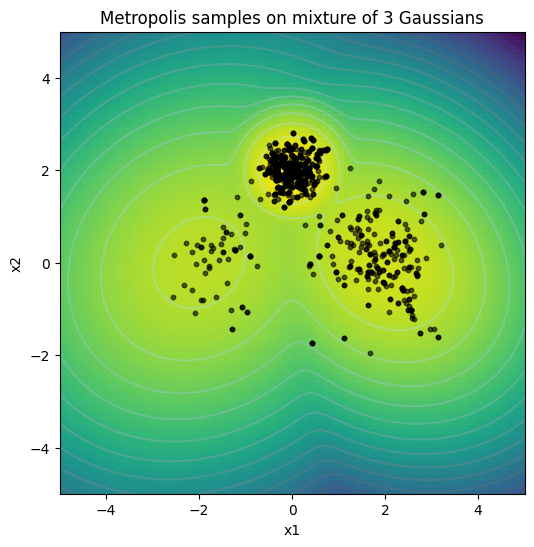

In [9]:
# Contour plot plus Metropolis path
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20)
cs = ax.contour(X, Y, Z, levels=20, cmap="Grays_r", alpha=0.3)
im = ax.imshow(
    Z,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin="lower",
    cmap="viridis",
    interpolation="nearest",
    aspect="auto",
)
ax.scatter(
    samples_metropolis[:, 0],
    samples_metropolis[:, 1],
    color="k",
    s=10,
    alpha=0.6,
    zorder=2,
)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Metropolis samples on mixture of 3 Gaussians")
plt.show()

# Sampling Comparison

## KL Divergence comparison

In [10]:
def log_true_density(x):
    vals = [
        w * multivariate_normal.pdf(x, mean=m, cov=c)
        for w, m, c in zip(weights, means, covs)
    ]
    return np.log(np.sum(vals))


def kl_samples_vs_target(samples):
    samples = np.asarray(samples)

    kde = gaussian_kde(samples.T)
    log_p_hat = np.log(kde(samples.T))
    log_p_true = np.array([log_true_density(x) for x in samples])

    return np.mean(log_p_hat - log_p_true)

In [11]:
# KL divergence for Hamiltonian Monte Carlo samples
kl_hmc = kl_samples_vs_target(samples_hmc)
print("KL divergence (samples vs target):", kl_hmc)

KL divergence (samples vs target): -0.03214359136742886


In [12]:
# KL divergence for Metropolis samples
kl_metropolis = kl_samples_vs_target(samples_metropolis)
print("KL divergence (samples vs target):", kl_metropolis)

KL divergence (samples vs target): -0.04524623216384949


## Plot HMC chain density

In [13]:
def plot_samples_density(samples, title="HMC"):
    x, y = np.mgrid[-5:5:0.1, -5:5:0.1]
    pos = np.vstack([x.ravel(), y.ravel()])

    gmm = GaussianMixture(n_components=len(weights))
    gmm.fit(samples)

    fitted_means = gmm.means_
    fitted_covs = gmm.covariances_
    fitted_weights = gmm.weights_

    fitted_gaussian = CustomGaussian(
        fitted_weights,
        fitted_means,
        fitted_covs,
    )

    log_density = np.array(
        [
            -fitted_gaussian.U(
                point,
            )
            for point in pos.T
        ]
    )
    log_density = log_density.reshape(x.shape)

    fig, ax = plt.subplots()
    ax.contourf(X, Y, Z, levels=20, cmap="viridis")
    ax.contour(X, Y, Z, levels=20, colors="white", linestyles="--", alpha=0.5)

    ax.contour(
        x,
        y,
        log_density,
        levels=20,
        colors="k",
        linestyles="-",
        linewidths=0.9,
    )

    ax.scatter(samples[:, 0], samples[:, 1], color="red", s=10, alpha=0.5)

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    # Add labels and a legend
    plt.axis("off")
    plt.title(f"Samples and fitted density (n={len(samples)}) - {title}")
    plt.show()


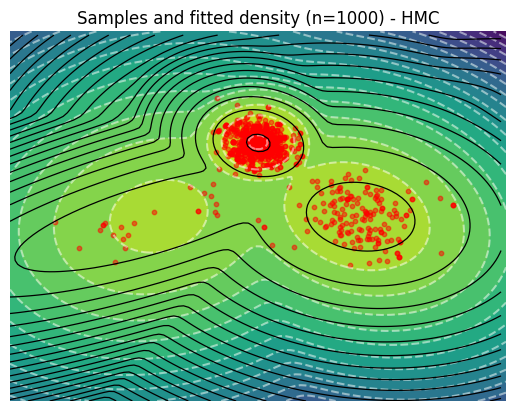

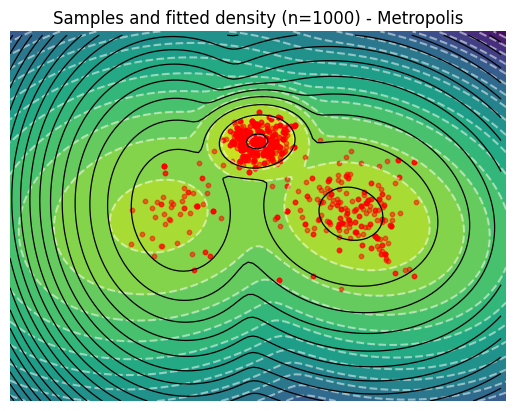

In [14]:
plot_samples_density(samples_hmc, "HMC")
plot_samples_density(samples_metropolis, "Metropolis")

In [15]:
# step_size = len(samples_hmc) // 10

# for num_samples in range(step_size, len(samples_hmc) + 1, step_size):
#     plot_samples_density(samples_hmc[:num_samples])

## MMD Comparison

In [16]:
def mmd_gmm_analytical(samples, weights, means, covs, sigma=1.0):
    """
    Calculates the squared Maximum Mean Discrepancy (MMD) between a set of samples
    and a Gaussian Mixture Model (GMM) using a Gaussian (RBF) kernel.

    Args:
        samples (list or np.ndarray): List of 2D numpy arrays or a single (N, D) array.
        weights (np.ndarray): GMM weights (K,).
        means (np.ndarray): GMM means (K, D).
        covs (np.ndarray): GMM covariances (K, D, D).
        sigma (float): Kernel bandwidth (standard deviation of the RBF kernel).

    Returns:
        float: The squared MMD value. (Closer to 0 means better match)

    """
    if isinstance(samples, list):
        X = np.vstack(samples)
    else:
        X = np.array(samples)

    N, D = X.shape
    K = len(weights)

    C_kernel = (2 * np.pi * (sigma**2)) ** (D / 2.0)

    diffs = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    sq_dists = np.sum(diffs**2, axis=-1)

    K_xx = np.exp(-sq_dists / (2 * sigma**2))
    term_A = np.sum(K_xx) / (N**2)

    term_B_sum = 0
    identity = np.eye(D)

    for k in range(K):
        cov_eff = covs[k] + (sigma**2) * identity
        pdf_vals = multivariate_normal.pdf(X, mean=means[k], cov=cov_eff)
        term_B_sum += weights[k] * np.mean(pdf_vals)

    term_B = C_kernel * term_B_sum

    term_C_sum = 0
    for k in range(K):
        for l in range(K):
            cov_eff = covs[k] + covs[l] + (sigma**2) * identity
            pdf_val = multivariate_normal.pdf(means[k], mean=means[l], cov=cov_eff)
            term_C_sum += weights[k] * weights[l] * pdf_val

    term_C = C_kernel * term_C_sum

    mmd2 = term_A - 2 * term_B + term_C
    return mmd2


100%|██████████| 999/999 [00:14<00:00, 67.34it/s] 


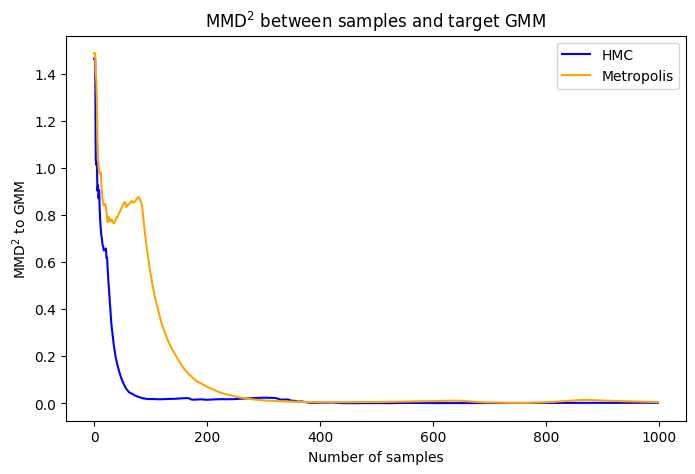

In [17]:
hmc_mmd2_list = []
metropolis_mmd2_list = []
for i in tqdm(range(1, len(samples_hmc))):
    hmc_mmd2 = mmd_gmm_analytical(samples_hmc[:i], weights, means, covs, sigma=1.0)
    metropolis_mmd2 = mmd_gmm_analytical(
        samples_metropolis[:i], weights, means, covs, sigma=1.0
    )
    hmc_mmd2_list.append(hmc_mmd2)
    metropolis_mmd2_list.append(metropolis_mmd2)

# Plot MMD^2 over number of samples
plt.figure(figsize=(8, 5))
plt.plot(hmc_mmd2_list, label="HMC", color="blue")
plt.plot(metropolis_mmd2_list, label="Metropolis", color="orange")
plt.xlabel("Number of samples")
plt.ylabel(r"MMD$^2$ to GMM")
plt.title("MMD$^2$ between samples and target GMM")
plt.legend()
plt.show()